# Covid Data Experiment

This project is dedicated to the application of machine learning algorithms and tools to analysis of covid pandemic. We try to find out the correlation and association between the containment of pandemics and the cultural values for each country, which are collected from the World Value Surveys.

Before we apply any algorithms to the data, we need to preprocess covid data and cultural data and combine both datasets. It's also necessary to do a exploratory data anaylsis on the data, for example, the correlation matrix visualized by heatmap, to see if there exists any relationship between containment of covid pandemics and cultural values.

## 1. Data cleaning
For this experiment, we use two datasets below: 

The Coronavirus (COVID-19) Cases and Deaths dataset is provided by World Health Organization and updated daily. It contains the historical record of covid cases and deaths for each country. The visualization, downloadable dataset and meta data information can be found [here](https://data.humdata.org/dataset/coronavirus-covid-19-cases-and-deaths)

The cultural dataset collected from World Value Survey for people of different countries, and processed by the previous experiment can be found [here](https://drive.google.com/file/d/1HZqj4cQpq1BJAnXOIXzgXoCVmmR20Rcm/view?usp=sharing). For demonstration purposes, we only use the representative countries selected [here](https://docs.google.com/spreadsheets/d/1yOFofd2kWRAhTduM3jKZifw91Dm6g1T5HO2i4xR-agA/edit?usp=sharing)

### 1.1 Request and load covid dataset
Since the covid dataset is updated daily, we request the covid dataset every time we use it to get the most recent data.

In [23]:
import requests

csv_url = "https://covid19.who.int/WHO-COVID-19-global-data.csv"

req = requests.get(csv_url)
url_content = req.content

output_file = "../data_set/covid_data.csv"
csv_file = open(output_file, 'wb')

csv_file.write(url_content)
csv_file.close()

In [24]:
import pandas as pd
import numpy as np

culture_file = "../data_set/cultural_data/clean_data/data_3.csv"

covid_data = pd.read_csv(output_file)
cultural_data = pd.read_csv(culture_file)

covid_data.tail()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
86625,2020-12-28,ZW,Zimbabwe,AFRO,0,12963,0,341
86626,2020-12-29,ZW,Zimbabwe,AFRO,185,13148,13,354
86627,2020-12-30,ZW,Zimbabwe,AFRO,0,13148,0,354
86628,2020-12-31,ZW,Zimbabwe,AFRO,477,13625,6,360
86629,2021-01-01,ZW,Zimbabwe,AFRO,242,13867,3,363


### 1.2 Preprocess covid dataset
We select only dates in Noverber because it makes sure that all countries are aware of the COVID and how to contain the pandemic. 

In [25]:
# Select date only in November
covid_data['Date_reported'] = pd.to_datetime(covid_data['Date_reported'])

start_date = pd.Timestamp("2020-11-01")
end_date = pd.Timestamp("2020-11-30")
covid_data = covid_data[(covid_data["Date_reported"] >= start_date) & (covid_data["Date_reported"] <= end_date)]

# Convert other attribtues to int
covid_data[['New_cases','Cumulative_cases', 'New_deaths', 'Cumulative_deaths']] = covid_data[['New_cases','Cumulative_cases', 'New_deaths', 'Cumulative_deaths']].astype(int)
covid_data

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
303,2020-11-01,AF,Afghanistan,EMRO,91,41425,3,1536
304,2020-11-02,AF,Afghanistan,EMRO,76,41501,0,1536
305,2020-11-03,AF,Afghanistan,EMRO,132,41633,5,1541
306,2020-11-04,AF,Afghanistan,EMRO,95,41728,3,1544
307,2020-11-05,AF,Afghanistan,EMRO,86,41814,4,1548
...,...,...,...,...,...,...,...,...
86593,2020-11-26,ZW,Zimbabwe,AFRO,110,9508,0,274
86594,2020-11-27,ZW,Zimbabwe,AFRO,115,9623,0,274
86595,2020-11-28,ZW,Zimbabwe,AFRO,91,9714,1,275
86596,2020-11-29,ZW,Zimbabwe,AFRO,108,9822,0,275


Visualize United States daily infected new cases and cumulative new cases in November. 

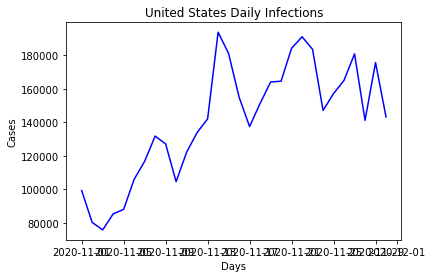

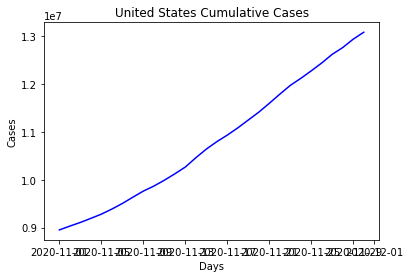

In [26]:
import matplotlib.pyplot as plt

us_new_cases = covid_data[covid_data["Country"] == "United States of America"]

plt.plot(us_new_cases["Date_reported"],us_new_cases["New_cases"], color='b',label="new cases")
plt.title("United States Daily Infections")
plt.xlabel("Days")
plt.ylabel("Cases")
plt.show()

plt.plot(us_new_cases["Date_reported"],us_new_cases["Cumulative_cases"], color='b',label="cumulative cases")
plt.title("United States Cumulative Cases")
plt.xlabel("Days")
plt.ylabel("Cases")
plt.show()

### 1.3 Measure the spread of virus


average rate of growth = new_cases / new_cases_yesterday averaged over days

In [29]:
countries = covid_data["Country"].unique().tolist()
countries.remove("Other")

country_df = pd.DataFrame(columns=["country","growth_rate"])

for country in countries:
    # Compute new cases / cumulative cases for each country
    new_cases = covid_data[covid_data["Country"] == country].New_cases
    cumulative_cases = covid_data[covid_data["Country"] == country].Cumulative_cases
    
    # Deal with 0 infections at the beginning
    new_cases = new_cases.loc[~(new_cases == 0)]
    past_new_cases = pd.concat([pd.DataFrame([1]),new_cases])
    past_new_cases = past_new_cases[:-1]

    # Check that there's sufficient infected cases to be statistically significant
    if cumulative_cases.iloc[-1] > 1000:
        growth_rate = [int(new_cases.iloc[i]) / int(past_new_cases.iloc[i]) for i in range(len(new_cases))]
        growth_rate = growth_rate[1:]

        average_growth_rate = np.mean(growth_rate)
    else:
        average_growth_rate = 0
        
    country_df.loc[len(country_df)] = [country, average_growth_rate]
    
print(country_df[country_df["country"]=="United States of America"])
country_df.sort_values(["growth_rate"],ascending=False).head(20)

                      country  growth_rate
225  United States of America     1.022688


,country,growth_rate
117,Lesotho,3.323641
150,Niger,2.884833
76,Gambia,2.455462
185,San Marino,2.447452
85,Guam,2.290491
133,Mayotte,2.208164
200,South Sudan,2.144283
79,Ghana,2.121381
40,Chad,2.081048
63,Equatorial Guinea,2.067113


Visualizaiton for the four top countries for the growth rate of infection.

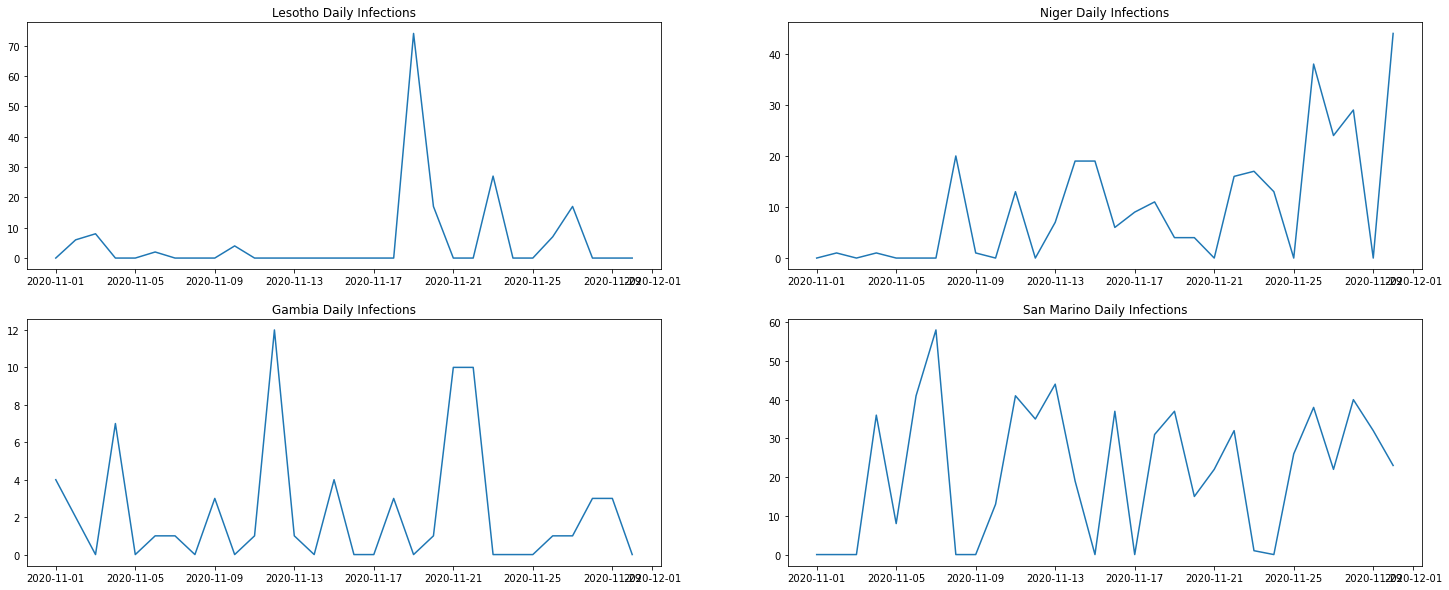

In [30]:
country_ls = ["Lesotho","Niger","Gambia","San Marino"]

fig, axes = plt.subplots(2,2,figsize=(25,10))
for i, ax in enumerate(axes.ravel()):
    country = country_ls[i]
    new_cases = covid_data[covid_data["Country"] == country]
    ax.set_title(country + " Daily Infections")
    ax.plot(new_cases["Date_reported"],new_cases["New_cases"])
    

### 1.4 Preprocess cultural dataset
We take average of numeric values for each country.

In [31]:
num_col = cultural_data.groupby(["V2"]).mean()

cleaned_df = num_col.reset_index()

We only select the representative countries for demonstration purposes

In [32]:
country_file = "../data_set/cultural_data/clean_data/country.csv"
country_name = pd.read_csv(country_file)

cleaned_df["V2"] = [country_name[country_name["index"]==x].iloc[0]["name"] for x in cleaned_df["V2"]]
cleaned_df

,V2,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,V240,V241,V242,V243,V245,V246,V248,V249,V250,V253
0,Algeria,0.033333,0.251944,0.345556,0.595556,0.125278,0.039167,0.649167,0.602778,0.312500,...,0.493333,1976.190833,0.262701,0.028958,0.494167,0.495833,0.449062,0.185859,0.535833,0.550000
1,Argentina,0.041100,0.189644,0.290291,0.627508,0.190291,0.481230,0.726214,0.651133,0.450485,...,0.531068,1968.757282,0.327383,0.058252,0.478641,0.491748,0.578883,0.229830,0.255340,0.817961
2,Australia,0.025502,0.153013,0.227714,0.486346,0.322501,0.623336,0.766870,0.680659,0.643873,...,0.557888,1957.844279,0.456624,0.170278,1.000000,0.496953,0.793077,0.219142,0.097495,0.724441
3,Brazil,0.044639,0.285330,0.271422,0.584567,0.130776,0.198295,0.753477,0.635487,0.377524,...,0.623822,1970.397712,0.323088,0.020693,0.496635,0.498654,0.496383,0.496573,0.216689,0.808462
4,Chile,0.032333,0.291000,0.178333,0.688000,0.176000,0.431667,0.694667,0.628000,0.492000,...,0.507000,1967.106000,0.336036,0.013500,0.495000,0.485000,0.560250,0.190694,0.238000,0.893750
5,China,0.046377,0.194493,0.350145,0.527101,0.270435,0.815217,0.668696,0.614638,0.690435,...,0.510435,1968.362174,0.336365,1.000000,1.000000,0.500000,0.542174,0.161318,0.279565,0.968424
6,Colombia,0.051808,0.337081,0.221340,0.674824,0.085979,0.197310,0.825617,0.668430,0.364418,...,0.503968,1971.360450,0.294121,0.008267,0.495370,0.491733,0.587880,0.177701,0.315476,0.819444
7,Ecuador,0.007210,0.322795,0.197726,0.517194,0.056572,0.159179,0.833333,0.654187,0.374376,...,0.515807,1972.628120,0.286891,0.061772,0.492928,0.493760,0.531198,0.176390,0.294509,0.831947
8,Estonia,0.050446,0.204392,0.265927,0.626006,0.240705,0.673625,0.623614,0.489454,0.536856,...,0.553816,1962.380952,0.392443,0.084149,0.431507,0.424658,0.702544,0.199549,0.131115,0.521445
9,Georgia,0.005546,0.096229,0.338880,0.577648,0.142263,0.062673,0.620078,0.453688,0.615641,...,0.539933,1969.302829,0.345248,0.012271,0.492928,0.498752,0.765911,0.204489,0.334443,0.558340


### 1.5 Combine both dataset
We select the intersections of countries in both datasets and combine them for future analysis. To do so, we add the growth_rate to the end of cultural data.

In [33]:
# Check for non overlapping countries
country_dif = set(cleaned_df["V2"]) - set(country_df["country"])
print(country_dif)

# Delete Hong Kong in cultural data
cleaned_df = cleaned_df[cleaned_df["V2"] != "Hong Kong"]

# Change the country name in covid data
rep_dic = {"Republic of Korea":"South Korea", "Russian Federation":"Russia", "United States of America":"United States"}
country_df = country_df.replace(rep_dic)

# Add growth_rate to cultural data
cleaned_df["growth_rate"] = [country_df[country_df["country"] == x]["growth_rate"].iloc[0] for x in cleaned_df["V2"]]

cleaned_df.to_csv("../data_set/cultural_covid_data.csv",index=False)

{'Hong Kong', 'Russia', 'South Korea', 'United States'}


<ipython-input-33-9956ba1923b9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["growth_rate"] = [country_df[country_df["country"] == x]["growth_rate"].iloc[0] for x in cleaned_df["V2"]]


### 1.6 Find correlation matrix

We plot the correlation matrix by selecting attributes index manually along with the growth rate and see the correlation between cultual attributes and covid growth rate.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


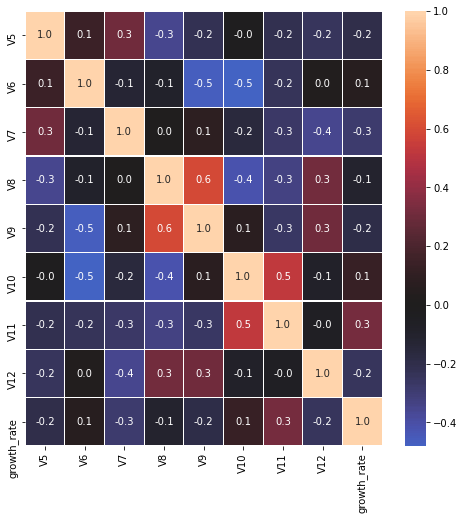

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Manually choose which attributes to show correlation by index
start_index = 2
end_index = 10

fig, ax = plt.subplots(figsize=(8,8)) 
cleaned_df.iloc[:,1:] = cleaned_df.iloc[:,1:].astype(float)

temp_df = pd.concat([cleaned_df.iloc[:,start_index:end_index],cleaned_df["growth_rate"]],axis=1)

corr = temp_df.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, fmt= '.1f', ax=ax)

We can also find cultural attributes with absolute value of correlation >= 0.3 and plot the heatmap for correlation.

,title,text,correlation coefficients
0,V11,State of health,0.318459
1,V48,Having a job is the best way for a woman to be an independent person.,-0.324896
2,V127,Having a strong leader who does not have to bother with parliament and elections,-0.363050
3,V142,Respect for human rights in your country,0.318798
4,V159,Position in society of people over 70?,0.340766
5,V170,Feel secure in my neighborhood,0.321523
6,V176,It happened that for the reason of security I didn’t carry much money,-0.363675
7,V209,Parents beating children,0.539138
8,V211,How proud are you to be [French]?,0.300896
9,V241,Year of birth 19__,0.328662


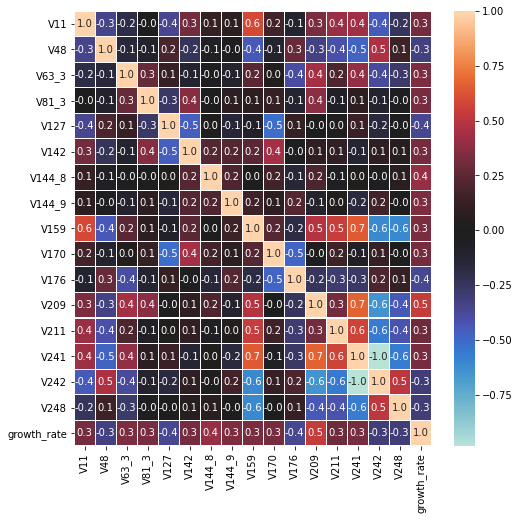

In [35]:
# Find all cultural attributes with absolute value of correlation >= 0.3
corr = cleaned_df.corr()
ls = list(corr[abs(corr["growth_rate"]) >= 0.3].index)

fig, ax = plt.subplots(figsize=(8,8))

temp_df = cleaned_df.loc[:,ls]

corr = temp_df.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, fmt= '.1f', ax=ax)

# Find corresponding questions with the important cultural attributes
WVS_questions = "../data_set/cultural_data/clean_data/WVS_topics_questions2.csv"
questions = pd.read_csv(WVS_questions, header=None)
questions.columns = ["title","min","max","type","norm_type","text"]

covid_questions = questions[questions["title"].isin(ls)][["title","text"]]
covid_corr = corr["growth_rate"].reset_index()
covid_corr.columns = ["title","growth_rate"]
covid_questions = pd.merge(covid_questions,covid_corr, on="title")
covid_questions.columns = ["title","text","correlation coefficients"]

pd.set_option('display.max_colwidth', None)

covid_questions